## Table of Contents

Data
- [Our Dummy Data](#data)

Overview
- [The Basics](#basics)
- [Grain](#grain)
- [GroupBy Object](#object)

Using It
- [Apply](#apply)
- [Transform](#transform)
- [Filter](#filter)

Misc
- [Grouper Object](#grouper)
- [Matplotlib](#matplotlib)
- [Gotchas](#gotchas)
- [Resources](#resources)

## Our Dummy Data <a id="data"></a>

For the purposes of demonstration, we're going to borrow the dataset used in [this post](http://pbpython.com/pandas-grouper-agg.html). It's basically some generic sales record data with account numbers, client names, prices, and timestamps.

In [1]:
import pandas as pd

dataUrl = r"https://github.com/chris1610/pbpython/blob/master/data/sample-salesv3.xlsx?raw=True"
df = pd.read_excel(dataUrl, parse_dates=['date'])
df.head()

,account number,name,sku,quantity,unit price,ext price,date
0,740150,Barton LLC,B1-20000,39,86.69,3380.91,2014-01-01 07:21:51
1,714466,Trantow-Barrows,S2-77896,-1,63.16,-63.16,2014-01-01 10:00:47
2,218895,Kulas Inc,B1-69924,23,90.70,2086.10,2014-01-01 13:24:58
3,307599,"Kassulke, Ondricka and Metz",S1-65481,41,21.05,863.05,2014-01-01 15:05:22
4,412290,Jerde-Hilpert,S2-34077,6,83.21,499.26,2014-01-01 23:26:55


How many different records do we have?

In [2]:
len(df)

1500

In terms of categorical data, it looks like most of our grain will be determined by `account number`, `name`, and whatever `sku` is.

In [3]:
df.nunique()

account number      20
name                20
sku                 30
quantity            50
unit price        1392
ext price         1491
date              1500
dtype: int64

And our date ranges span

In [4]:
print(df['date'].min(), df['date'].max())

2014-01-01 07:21:51 2014-12-31 12:48:35


<hr></hr>
##  The Basics <a id="basics"></a>

### Split, Apply, Combine

At the heart of it, any time you use Group By, it's because you're trying to do any of the following:

* **Splitting** the data based on some criteria
* **Applying** a function to each group independently
* **Combining** the results into a data structure

In SQL, this is achieved in one shot with the following syntax

``` mysql
SELECT col1, col2, AVG(col3)
FROM table
GROUP BY Col1, Col2
```

However, this quickly becomes cumbersome when exploring the data, as each new field you add requires rerunning the query.

By splitting this process up between the `split` and `apply` steps, we can stage the groups in memory and flexibly leverage the `GroupBy` object's powerful methods, which generally do one of two things:

**Aggregation**: computing a summary statistic(s) about each group, e.g. per-group:
     
* sums
* means
* counts
    
This collapses the data to the grain that the data is grouped at.

**Transformation**: perform some group-specific computations. e.g.:

* Standardizing data within a group
* Filling missing data within groups using a value derived from the group

This returns a *like-indexed* dataset. So you will wind up with as many records of data as your initial population.

<hr></hr>
## Grain <a id="grain"></a>

###  Under the Hood

Creating a `GroupBy` object is pretty straight-forward. You give `pandas` some data and you tell it what to group by.

This creates a ``DataFrameGroupBy`` object which is a sub-class of the ``NDFrameGroupBy`` class, which is in-turn a sub-class of the ``GroupBy`` class.

In [5]:
gb = df.groupby(by='name')
gb

Behind the scenes, all that's happening is that it's taking the index of the DataFrame

In [6]:
print(df.index)

RangeIndex(start=0, stop=1500, step=1)


And making a simple `dict` by getting all of the unique values in your group definition as keys

In [7]:
df['name'].unique()

array(['Barton LLC', 'Trantow-Barrows', 'Kulas Inc',
       'Kassulke, Ondricka and Metz', 'Jerde-Hilpert', 'Koepp Ltd',
       'Fritsch, Russel and Anderson', 'Kiehn-Spinka', 'Keeling LLC',
       'Frami, Hills and Schmidt', 'Stokes LLC', 'Kuhn-Gusikowski',
       'Herman LLC', 'White-Trantow', 'Sanford and Sons', 'Pollich LLC',
       'Will LLC', 'Cronin, Oberbrunner and Spencer',
       'Halvorson, Crona and Champlin', 'Purdy-Kunde'], dtype=object)

The corresponding values are just the indexes in the DataFrame that match these keys.

This means that creating new `GroupBy` objects is both quick and cheap (your underlying data is only saved once!). It also makes it very easy to inspect the data by group.

In [8]:
gb.get_group('Kulas Inc').head()

,account number,name,sku,quantity,unit price,ext price,date
2,218895,Kulas Inc,B1-69924,23,90.70,2086.10,2014-01-01 13:24:58
6,218895,Kulas Inc,B1-65551,2,31.10,62.20,2014-01-02 10:57:23
33,218895,Kulas Inc,S1-06532,3,22.36,67.08,2014-01-09 23:58:27
36,218895,Kulas Inc,S2-34077,16,73.04,1168.64,2014-01-10 12:07:30
43,218895,Kulas Inc,B1-50809,43,47.21,2030.03,2014-01-12 01:54:37


After you `groupby`, every row of the original dataset is going to be accounted for.

In [9]:
sum([len(gb.get_group(x)) for x in gb.groups.keys()])

1500

### Grouping

And so with this intuition in mind, you should think of the grouping criteria at the *index-level*.

For example:

#### Values in the Data

This comes in two flavors:

1) The raw data

In [10]:
print(len(df.groupby(by=df['name'])))

20


2) Or for convenience, the column name itself

In [11]:
print(len(df.groupby(by='name')))

20


To get even more granular than one field, pass the `by` argument in as a list of values

In [12]:
print(len(df.groupby(by=['name', 'sku'])))
print(len(df.groupby(by=[df['name'], df['sku']])))

544
544


#### Numpy Arrays the same length as the axis

Similarly, you can write your own logic as long as the output has the same index as the original data.

Consider a scenario where you define a specific group of clients and want to compare their performance against the rest of the population.

In [13]:
ourGroup = ['Kassulke, Ondricka and Metz', 'Jerde-Hilpert', 'Koepp Ltd']
tf = df['name'].isin(ourGroup)
tf.value_counts()

False    1265
True      235
Name: name, dtype: int64

This returns a Numpy array with True/False values for each row that, of course, have the same index

In [14]:
all(tf.index == df.index)

True

Using this is as easy as

In [15]:
gb = df.groupby(tf)
gb.groups.keys()

dict_keys([False, True])

As you can see, this partitions our data into two groups

In [16]:
print(len(gb.get_group(False)), len(gb.get_group(True)))

1265 235


That match our `value_counts` above perfectly.

#### Functions/Maps applied to the axes themselves

Assume that we have a real simple dummy dataset

In [17]:
import numpy as np

abc = pd.DataFrame({'A' : ['foo', 'bar', 'foo', 'bar',
                           'foo', 'bar', 'foo', 'foo'],
                       'B' : ['one', 'one', 'two', 'three',
                              'two', 'two', 'one', 'three'],
                       'C' : np.random.randn(8),
                       'D' : np.random.randn(8)})
abc

,A,B,C,D
0,foo,one,1.265959,0.555853
1,bar,one,-0.544206,0.358620
2,foo,two,1.000534,-0.835887
3,bar,three,1.872789,0.444664
4,foo,two,1.684510,0.558262
5,bar,two,0.970853,0.880734
6,foo,one,1.366091,0.760195
7,foo,three,1.638540,0.592039


And we want to group by whether the column is a consonant or not

In [18]:
# function implementation
def get_letter_type(letter):
    if letter.lower() in 'aeiou':
        return 'vowel'
    else:
        return 'consonant'

# dict implementation
letter_mapping = {'A': 'vowel', 'B':'consonant', 
                  'C': 'consonant', 'D': 'consonant'}

In [19]:
# axis=1 uses the column headers
grouped1 = abc.groupby(get_letter_type, axis=1)
grouped2 = abc.groupby(letter_mapping, axis=1)

print(grouped1.groups.values())
print(grouped2.groups.values())

dict_values([Index(['B', 'C', 'D'], dtype='object'), Index(['A'], dtype='object')])
dict_values([Index(['B', 'C', 'D'], dtype='object'), Index(['A'], dtype='object')])


<hr></hr>
## GroupBy Properties <a id="object"></a>

Before we get into the *Transform* discussed above, here's a quick look at some of the features available at the moment of instantiation.

In [20]:
gb = df.groupby('name')
gb

Count of records in each group

In [21]:
gb.size()

name
Barton LLC                         82
Cronin, Oberbrunner and Spencer    67
Frami, Hills and Schmidt           72
Fritsch, Russel and Anderson       81
Halvorson, Crona and Champlin      58
Herman LLC                         62
Jerde-Hilpert                      89
Kassulke, Ondricka and Metz        64
Keeling LLC                        74
Kiehn-Spinka                       79
Koepp Ltd                          82
Kuhn-Gusikowski                    73
Kulas Inc                          94
Pollich LLC                        73
Purdy-Kunde                        53
Sanford and Sons                   71
Stokes LLC                         72
Trantow-Barrows                    94
White-Trantow                      86
Will LLC                           74
dtype: int64

As mentioned earlier, on the backend, all a `GroupBy` object is is a `dict` of keys: group, value: index.

Therefore, inspecting what groups exist is simple.

In [22]:
print(gb.groups.keys())

dict_keys(['Barton LLC', 'Cronin, Oberbrunner and Spencer', 'Frami, Hills and Schmidt', 'Fritsch, Russel and Anderson', 'Halvorson, Crona and Champlin', 'Herman LLC', 'Jerde-Hilpert', 'Kassulke, Ondricka and Metz', 'Keeling LLC', 'Kiehn-Spinka', 'Koepp Ltd', 'Kuhn-Gusikowski', 'Kulas Inc', 'Pollich LLC', 'Purdy-Kunde', 'Sanford and Sons', 'Stokes LLC', 'Trantow-Barrows', 'White-Trantow', 'Will LLC'])


as is the distinct number of groups that we have

In [23]:
print(len(gb.groups))

20


You can use the keys to either get the indexes that roll up

In [24]:
gb.groups['Barton LLC']

Int64Index([   0,   85,   91,   96,   99,  105,  117,  125,  158,  182,  183,
             195,  202,  226,  237,  268,  306,  310,  397,  420,  423,  427,
             430,  456,  459,  482,  505,  516,  524,  530,  540,  605,  622,
             635,  636,  646,  650,  652,  666,  667,  691,  718,  733,  740,
             830,  853,  854,  895,  906,  907,  915,  920,  930,  963,  985,
             989, 1008, 1015, 1017, 1019, 1031, 1071, 1077, 1078, 1081, 1094,
            1108, 1132, 1147, 1149, 1158, 1175, 1208, 1218, 1257, 1321, 1330,
            1346, 1350, 1414, 1422, 1473],
           dtype='int64')

or the relevant subset of the base DataFrame

In [25]:
gb.get_group('Barton LLC').head()

,account number,name,sku,quantity,unit price,ext price,date
0,740150,Barton LLC,B1-20000,39,86.69,3380.91,2014-01-01 07:21:51
85,740150,Barton LLC,B1-50809,8,19.60,156.80,2014-01-20 01:48:47
91,740150,Barton LLC,B1-53102,1,68.06,68.06,2014-01-20 13:27:52
96,740150,Barton LLC,S2-16558,2,90.91,181.82,2014-01-21 21:21:01
99,740150,Barton LLC,B1-86481,20,30.41,608.20,2014-01-22 16:33:51


Lastly, using the `dict`-like properties, we can cleanly iterate through `GroupBy` objects

In [26]:
from itertools import islice

# only looking through the first two groups
# to save space
for name, group in islice(gb, 2):
    print(name)
    print(type(group))
    print(group.head())
    print('\n'*2)

Barton LLC
<class 'pandas.core.frame.DataFrame'>
    account number        name       sku  quantity  unit price  ext price  \
0           740150  Barton LLC  B1-20000        39       86.69    3380.91   
85          740150  Barton LLC  B1-50809         8       19.60     156.80   
91          740150  Barton LLC  B1-53102         1       68.06      68.06   
96          740150  Barton LLC  S2-16558         2       90.91     181.82   
99          740150  Barton LLC  B1-86481        20       30.41     608.20   

                  date  
0  2014-01-01 07:21:51  
85 2014-01-20 01:48:47  
91 2014-01-20 13:27:52  
96 2014-01-21 21:21:01  
99 2014-01-22 16:33:51  



Cronin, Oberbrunner and Spencer
<class 'pandas.core.frame.DataFrame'>
     account number                             name       sku  quantity  \
51           257198  Cronin, Oberbrunner and Spencer  B1-05914         8   
110          257198  Cronin, Oberbrunner and Spencer  S2-16558        41   
148          257198  Cronin, Oberbrun

## Apply <a id="apply"></a>

You want to use `apply` when you mean to consolidate all of your data down to the grain of your groups.

#### Example: Max - Min per Client group

Say you wanted to know, per client, what the spread of their unit price was, you could do this one of two ways:

1) Making a general function that expects a Series, grouping, then specifying which column will be the series

In [27]:
def spread_series(arr):
    return arr.max() - arr.min()

df.groupby('name')['unit price'].apply(spread_series).head()

name
Barton LLC                         89.24
Cronin, Oberbrunner and Spencer    86.59
Frami, Hills and Schmidt           83.04
Fritsch, Russel and Anderson       88.96
Halvorson, Crona and Champlin      87.95
Name: unit price, dtype: float64

2) Same function, but this time it expects a DataFrame and will filter at the Series level in the function

In [28]:
def spread_df(arr):
    return arr['unit price'].max() - arr['unit price'].min()

df.groupby('name').apply(spread_df).head()

name
Barton LLC                         89.24
Cronin, Oberbrunner and Spencer    86.59
Frami, Hills and Schmidt           83.04
Fritsch, Russel and Anderson       88.96
Halvorson, Crona and Champlin      87.95
dtype: float64

####  .agg

A hidden third option is to use the swanky `agg` funtion that will iterate through columns and try to apply your function

In [29]:
df.groupby('name').agg(spread_series).head()

,account number,quantity,unit price,ext price,date
name,,,,,
Barton LLC,0,50,89.24,4609.41,356 days 23:54:35
"Cronin, Oberbrunner and Spencer",0,46,86.59,4103.63,349 days 12:26:02
"Frami, Hills and Schmidt",0,47,83.04,4221.14,360 days 14:50:24
"Fritsch, Russel and Anderson",0,48,88.96,3918.36,360 days 18:30:36
"Halvorson, Crona and Champlin",0,47,87.95,4082.02,345 days 18:32:02


You can also pass it a list of Series-friendly functions and it will apply all of them

In [30]:
df.groupby('name').agg([spread_series, np.mean, sum]).head()

account number                    \
                                 spread_series    mean       sum   
name                                                               
Barton LLC                                   0  740150  60692300   
Cronin, Oberbrunner and Spencer              0  257198  17232266   
Frami, Hills and Schmidt                     0  786968  56661696   
Fritsch, Russel and Anderson                 0  737550  59741550   
Halvorson, Crona and Champlin                0  604255  35046790   

                                     quantity                     unit price  \
                                spread_series       mean   sum spread_series   
name                                                                           
Barton LLC                                 50  24.890244  2041         89.24   
Cronin, Oberbrunner and Spencer            46  24.970149  1673         86.59   
Frami, Hills and Schmidt                   47  26.430556  1903         83.04   
Fritsch, Russel and Anderson               48  26.074074  2112         88.96   
Halvorson, Crona and Champlin              47  22.137931  1284         87.95   

                                                        ext price  \
                                      mean      sum spread_series   
name                                                                
Barton LLC                       53.769024  4409.06       4609.41   
Cronin, Oberbrunner and Spencer  49.805821  3336.99       4103.63   
Frami, Hills and Schmidt         54.756806  3942.49       4221.14   
Fritsch, Russel and Anderson     53.708765  4350.41       3918.36   
Halvorson, Crona and Champlin    55.946897  3244.92       4082.02   

                                                         
                                        mean        sum  
name                                                     
Barton LLC                       1334.615854  109438.50  
Cronin, Oberbrunner and Spencer  1339.321642   89734.55  
Frami, Hills and Schmidt         1438.466528  103569.59  
Fritsch, Russel and Anderson     1385.366790  112214.71  
Halvorson, Crona and Champlin    1206.971724   70004.36

Finally, you can pass `agg` a `dict` that specifies which functions to call per column.

The usefulness of this functionality in report automation should be pretty straight-forward

In [31]:
def diff_days(arr):
    return (arr.max() - arr.min()).days

result = df.groupby('name').agg({'account number':'mean', 'quantity':'sum', 
                                 'unit price':'mean', 'ext price':'mean',
                                 'date':diff_days})

# Label your data accordingly
result.columns = ['Account Number', 'Total Orders', 'Avg Unit Price', 
                  'Avg Ext Price', 'Days a Client']
result.index.name = 'Client'

result

,Account Number,Total Orders,Avg Unit Price,Avg Ext Price,Days a Client
Client,,,,,
Barton LLC,740150,2041,53.769024,1334.615854,356
"Cronin, Oberbrunner and Spencer",257198,1673,49.805821,1339.321642,349
"Frami, Hills and Schmidt",786968,1903,54.756806,1438.466528,360
"Fritsch, Russel and Anderson",737550,2112,53.708765,1385.366790,360
"Halvorson, Crona and Champlin",604255,1284,55.946897,1206.971724,345
Herman LLC,141962,1538,52.566935,1336.532258,353
Jerde-Hilpert,412290,1999,52.084719,1265.072247,353
"Kassulke, Ondricka and Metz",307599,1647,51.043125,1350.797969,357
Keeling LLC,688981,1806,57.076081,1363.977027,356


##  Transform <a id="transform"></a>

Transform is used when you want to maintain the structure of your current DataFrame, but generate new data at the group-level.

**Note:** The functions that you write need to written to process `Series` objects.

####  Ex: Largest order per Client

In [32]:
# apparent 'ext price' has been order total this whole time
df['largest order'] = df.groupby('name')['ext price'].transform(lambda x: x.max())
df.head()

,account number,name,sku,quantity,unit price,ext price,date,largest order
0,740150,Barton LLC,B1-20000,39,86.69,3380.91,2014-01-01 07:21:51,4543.96
1,714466,Trantow-Barrows,S2-77896,-1,63.16,-63.16,2014-01-01 10:00:47,4444.30
2,218895,Kulas Inc,B1-69924,23,90.70,2086.10,2014-01-01 13:24:58,4590.81
3,307599,"Kassulke, Ondricka and Metz",S1-65481,41,21.05,863.05,2014-01-01 15:05:22,4418.47
4,412290,Jerde-Hilpert,S2-34077,6,83.21,499.26,2014-01-01 23:26:55,3791.62


### Filling Missing Data

In [33]:
test = df.head(50).copy()
test.head()

,account number,name,sku,quantity,unit price,ext price,date,largest order
0,740150,Barton LLC,B1-20000,39,86.69,3380.91,2014-01-01 07:21:51,4543.96
1,714466,Trantow-Barrows,S2-77896,-1,63.16,-63.16,2014-01-01 10:00:47,4444.30
2,218895,Kulas Inc,B1-69924,23,90.70,2086.10,2014-01-01 13:24:58,4590.81
3,307599,"Kassulke, Ondricka and Metz",S1-65481,41,21.05,863.05,2014-01-01 15:05:22,4418.47
4,412290,Jerde-Hilpert,S2-34077,6,83.21,499.26,2014-01-01 23:26:55,3791.62


In [34]:
test.loc[[0, 2], 'unit price'] = np.nan
test.head()

,account number,name,sku,quantity,unit price,ext price,date,largest order
0,740150,Barton LLC,B1-20000,39,NaN,3380.91,2014-01-01 07:21:51,4543.96
1,714466,Trantow-Barrows,S2-77896,-1,63.16,-63.16,2014-01-01 10:00:47,4444.30
2,218895,Kulas Inc,B1-69924,23,NaN,2086.10,2014-01-01 13:24:58,4590.81
3,307599,"Kassulke, Ondricka and Metz",S1-65481,41,21.05,863.05,2014-01-01 15:05:22,4418.47
4,412290,Jerde-Hilpert,S2-34077,6,83.21,499.26,2014-01-01 23:26:55,3791.62


In [35]:
def fill_with_mean(arr):
    return arr.mean()

test.groupby('name').transform(fill_with_mean).head()

,account number,quantity,unit price,ext price,largest order
0,740150,39.000000,NaN,3380.910000,4543.96
1,714466,17.285714,57.258571,1064.988571,4444.30
2,218895,14.666667,53.544000,918.010000,4590.81
3,307599,31.000000,22.176667,743.643333,4418.47
4,412290,17.000000,52.440000,681.120000,3791.62


### Outlier Detection

Let's stuff a ton of normally-distributed dummy data into a `DataFrame`

In [36]:
data = np.random.normal(size=(100000, 5))
dummy = pd.DataFrame(data, columns=['a', 'b', 'c', 'd', 'e'])

And assign them to arbitrary groups (counting off by 3s)

In [37]:
from itertools import cycle

countoff = cycle([1, 2, 3])
mapping = dict(zip(dummy.index, countoff))
dummy.groupby(mapping).size()

1    33334
2    33333
3    33333
dtype: int64

A good rule of thumb for an outlier is finding the quartiles of each data, $Q_1, Q_2, Q_3, Q_4$ and then fishing for observations, $x$ that are either:

<center>$x < Q_1 - 1.5 * (Q_3 - Q_1)$</center>

and

<center>$x > Q_3 + 1.5 * (Q_3 - Q_1)$</center>

Easy enough!

In [38]:
def find_outliers(arr):
    '''Given a pd.Series of numeric type'''
    q3 = arr.quantile(.75)
    q1 = arr.quantile(.25)
    
    return ((arr < (q1 - (1.5*(q3-q1)))) | (arr > (q3 + (1.5*(q3-q1)))))

outliersByCell = dummy.groupby(mapping).transform(find_outliers)
pd.Series(outliersByCell.values.ravel()).value_counts()

False    496642
True       3358
dtype: int64

Hey, so some cells are outliers! But what rows contained outlier data?

Well we can be cheeky and use the property that items of `bool` type are represented as `True=1` and `False=0` on the backend and sum them. Anything greater than 0 has an outlier somewhere.

In [39]:
outliersByRow = outliersByCell.sum(axis=1) > 0
print(outliersByRow.value_counts())
outliersByCell[outliersByRow].head()

False    96684
True      3316
dtype: int64


,a,b,c,d,e
51,False,False,False,False,True
99,False,False,False,True,False
145,False,False,True,False,False
148,False,False,False,False,True
151,False,False,True,False,False


So if we're doing some rudimentary modelling, this will likely be one of our earlier steps.

Next, we want to be able to hold back data that's going to throw off our model. Which transitions nicely into...

## Filter <a id="filter"></a>

Anyone comfortable with `pandas` will likely be used to using Numpy masks to trim down their datasets. However, the `filter` functionality allows us to be even more specific in our exclusions.

##### Ex: Filtering Out Low-Participation Clients

If we ever found ourselves wanting to filter out clients that had, arbitrarily, less than 64 orders, we would want to find the top 3 of this series

In [40]:
df.groupby('account number').size().sort_values().head()

account number
163416    53
604255    58
141962    62
307599    64
257198    67
dtype: int64

Filtering this out is easy as writing a filtering function-- **at the `DataFrame` level**-- of things that you want to *keep*

In [41]:
def no_small_potatoes(x):
    return len(x) > 64

results = df.groupby('account number').filter(no_small_potatoes)['account number']
results.isin([163416, 604255, 141961]).value_counts()

False    1263
Name: account number, dtype: int64

##### Ex: Clients with High Incidence of Issues

Our dataset had negative `ext price` values, which seemed to indicate returns/refunds.

In [42]:
df.groupby('account number')['quantity'].apply(lambda x: sum(x < 0)) \
                                        .sort_values(ascending=False)

account number
729833    4
218895    4
424914    3
714466    3
527099    3
688981    2
740150    2
383080    1
146832    1
239344    1
307599    1
141962    1
412290    1
672390    1
604255    0
257198    0
642753    0
163416    0
737550    0
786968    0
Name: quantity, dtype: int64

A few clients had 0 or 1 returns. This is ideal, but suppose we want to zero in on clients 3 or more

In [43]:
def lots_of_returns(x):
    return sum(x['quantity'] < 0) >= 3

results = df.groupby('account number').filter(lots_of_returns)
print(results['account number'].unique())
results.head()

[714466 218895 729833 424914 527099]


,account number,name,sku,quantity,unit price,ext price,date,largest order
1,714466,Trantow-Barrows,S2-77896,-1,63.16,-63.16,2014-01-01 10:00:47,4444.30
2,218895,Kulas Inc,B1-69924,23,90.70,2086.10,2014-01-01 13:24:58,4590.81
5,714466,Trantow-Barrows,S2-77896,17,87.63,1489.71,2014-01-02 10:07:15,4444.30
6,218895,Kulas Inc,B1-65551,2,31.10,62.20,2014-01-02 10:57:23,4590.81
7,729833,Koepp Ltd,S1-30248,8,33.25,266.00,2014-01-03 06:32:11,4708.41


<hr></hr>
## The `Grouper` Object <a id="grouper"></a>

The `pd.Grouper` object largely exists to make `groupby` operations with `datetime` values less of a headache.

In [44]:
df.head()

,account number,name,sku,quantity,unit price,ext price,date,largest order
0,740150,Barton LLC,B1-20000,39,86.69,3380.91,2014-01-01 07:21:51,4543.96
1,714466,Trantow-Barrows,S2-77896,-1,63.16,-63.16,2014-01-01 10:00:47,4444.30
2,218895,Kulas Inc,B1-69924,23,90.70,2086.10,2014-01-01 13:24:58,4590.81
3,307599,"Kassulke, Ondricka and Metz",S1-65481,41,21.05,863.05,2014-01-01 15:05:22,4418.47
4,412290,Jerde-Hilpert,S2-34077,6,83.21,499.26,2014-01-01 23:26:55,3791.62


#### The old way

In [45]:
# resample only works on an index, not a column
df.set_index('date').resample('M')['ext price'].agg(['sum', 'count'])

,sum,count
date,,
2014-01-31,185361.66,134
2014-02-28,146211.62,108
2014-03-31,203921.38,142
2014-04-30,174574.11,134
2014-05-31,165418.55,132
2014-06-30,174089.33,128
2014-07-31,191662.11,128
2014-08-31,153778.59,117
2014-09-30,168443.17,118



When you introduce regular groupby operations, the syntax gets cumbersome.


In [46]:
df.set_index('date').groupby('name')['ext price'].resample('M').sum().head(20)

name                             date      
Barton LLC                       2014-01-31     6177.57
                                 2014-02-28    12218.03
                                 2014-03-31     3513.53
                                 2014-04-30    11474.20
                                 2014-05-31    10220.17
                                 2014-06-30    10463.73
                                 2014-07-31     6750.48
                                 2014-08-31    17541.46
                                 2014-09-30    14053.61
                                 2014-10-31     9351.68
                                 2014-11-30     4901.14
                                 2014-12-31     2772.90
Cronin, Oberbrunner and Spencer  2014-01-31     1141.75
                                 2014-02-28    13976.26
                                 2014-03-31    11691.62
                                 2014-04-30     3685.44
                                 2014-05-31     6760.11
    

#### Instead
We can do all of the group definition in one shot with Grouper

In [47]:
df.groupby(['name', pd.Grouper(key='date', freq='M')])['ext price'].sum().head(20)

name                             date      
Barton LLC                       2014-01-31     6177.57
                                 2014-02-28    12218.03
                                 2014-03-31     3513.53
                                 2014-04-30    11474.20
                                 2014-05-31    10220.17
                                 2014-06-30    10463.73
                                 2014-07-31     6750.48
                                 2014-08-31    17541.46
                                 2014-09-30    14053.61
                                 2014-10-31     9351.68
                                 2014-11-30     4901.14
                                 2014-12-31     2772.90
Cronin, Oberbrunner and Spencer  2014-01-31     1141.75
                                 2014-02-28    13976.26
                                 2014-03-31    11691.62
                                 2014-04-30     3685.44
                                 2014-05-31     6760.11
    

Making this an annual aggregation is as easy as changing the `freq` argument

In [48]:
df.groupby(['name', pd.Grouper(key='date', freq='A-DEC')])['ext price'].sum().head(20)

name                             date      
Barton LLC                       2014-12-31    109438.50
Cronin, Oberbrunner and Spencer  2014-12-31     89734.55
Frami, Hills and Schmidt         2014-12-31    103569.59
Fritsch, Russel and Anderson     2014-12-31    112214.71
Halvorson, Crona and Champlin    2014-12-31     70004.36
Herman LLC                       2014-12-31     82865.00
Jerde-Hilpert                    2014-12-31    112591.43
Kassulke, Ondricka and Metz      2014-12-31     86451.07
Keeling LLC                      2014-12-31    100934.30
Kiehn-Spinka                     2014-12-31     99608.77
Koepp Ltd                        2014-12-31    103660.54
Kuhn-Gusikowski                  2014-12-31     91094.28
Kulas Inc                        2014-12-31    137351.96
Pollich LLC                      2014-12-31     87347.18
Purdy-Kunde                      2014-12-31     77898.21
Sanford and Sons                 2014-12-31     98822.98
Stokes LLC                       2014-12-31 

## Matplotlib <a id="matplotlib"></a>

`GroupBy` objects also play pretty well with `matplotlib`... with some finagling

In [49]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\nhounshell\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [50]:
df.head()

,account number,name,sku,quantity,unit price,ext price,date,largest order
0,740150,Barton LLC,B1-20000,39,86.69,3380.91,2014-01-01 07:21:51,4543.96
1,714466,Trantow-Barrows,S2-77896,-1,63.16,-63.16,2014-01-01 10:00:47,4444.30
2,218895,Kulas Inc,B1-69924,23,90.70,2086.10,2014-01-01 13:24:58,4590.81
3,307599,"Kassulke, Ondricka and Metz",S1-65481,41,21.05,863.05,2014-01-01 15:05:22,4418.47
4,412290,Jerde-Hilpert,S2-34077,6,83.21,499.26,2014-01-01 23:26:55,3791.62


What if we wanted to inspect the count of issues vs the count of orders by month?

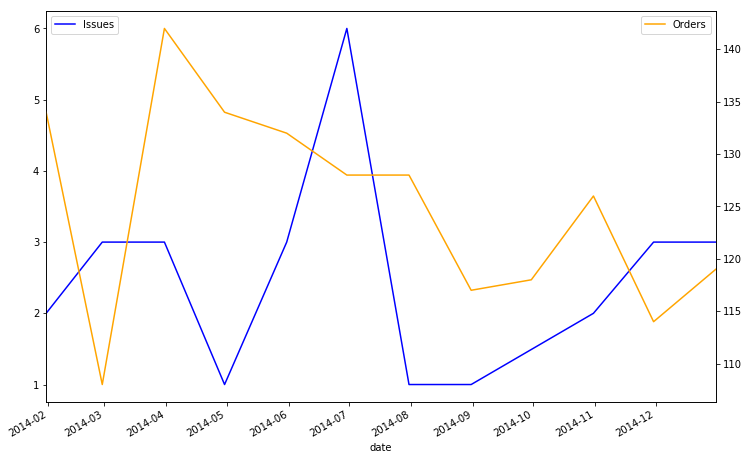

In [51]:
fig, ax = plt.subplots(figsize=(12, 8))

monthlyClip = pd.Grouper(key='date', freq='M')

problemOrder = df['quantity'] < 0
problemsPerMonth = df.groupby([problemOrder, monthlyClip]).size()[True]
problemsPerMonth.plot(ax=ax, c='b', label='Issues')
ax.legend(loc=2)

ordersPerMonth = df.groupby(monthlyClip).size()
ax2 = ax.twinx()
ax2.plot(ordersPerMonth, c='orange', label='Orders')
ax2.legend(loc=0)

Or if we wanted to see if there was a discernable difference in the price/quantity behavior of our 5 biggest spenders?

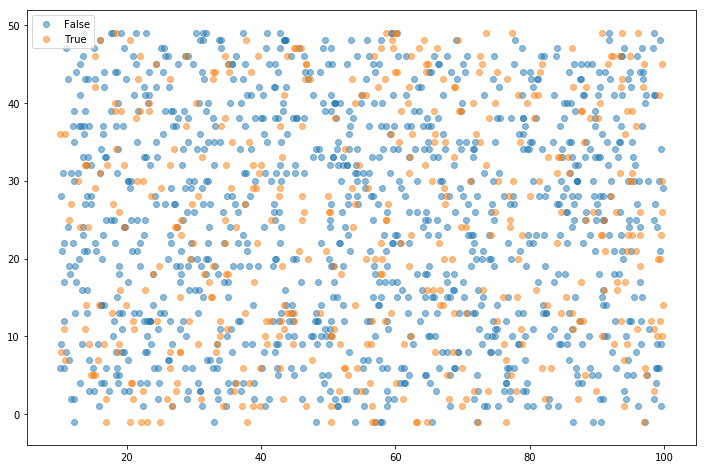

In [52]:
fiveBiggestSpenders = (df.groupby(['name'])['unit price']
                          .sum()
                          .sort_values(ascending=False)
                          .index[:5])
gb = df.groupby(df['name'].isin(fiveBiggestSpenders))

fig, ax = plt.subplots(figsize=(12, 8))


for name, group in gb:
    ax.scatter(group['unit price'], group['quantity'], alpha=.5, label=name)
    
plt.legend()

Or wanted to examine our cumulative earnings per Client over the course of the year?

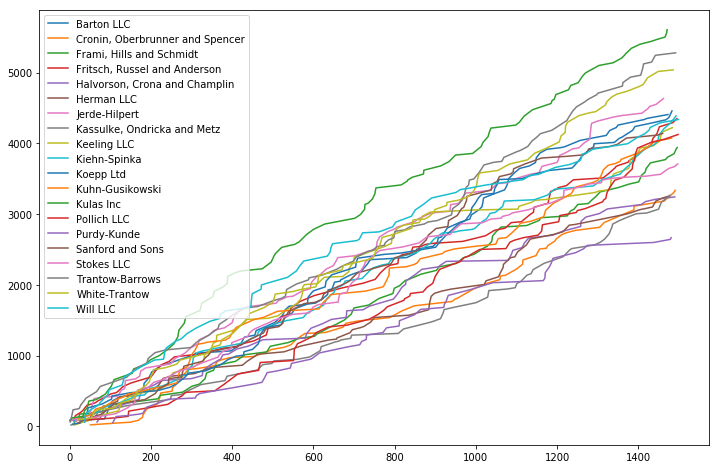

In [53]:
gb = df.groupby('name')

fig, ax = plt.subplots(figsize=(12, 8))

for name, group in gb:
    ax.plot(group['unit price'].cumsum(), label=name)

ax.legend()

<hr></hr>
## Gotchas <a id="gotchas"></a>

### Multi-Index

Suppose that we wanted to know what day of the week each client did business with us on.

This is, as discussed above:

1) Creating a `Numpy` array with the same index as the `DataFrame` representing `day of week`
2) Grouping by that and the client's name

In [54]:
dow = df['date'].dt.dayofweek

df.groupby(['name', dow]).size().head(20)

name                             date
Barton LLC                       0        8
                                 1       12
                                 2       15
                                 3        8
                                 4       20
                                 5       10
                                 6        9
Cronin, Oberbrunner and Spencer  0       12
                                 1       12
                                 2        7
                                 3        8
                                 4       11
                                 5       10
                                 6        7
Frami, Hills and Schmidt         0       11
                                 1        8
                                 2       10
                                 3        9
                                 4       12
                                 5        7
dtype: int64

But this is damn gross. Furthermore, we want the values in the `date` column to be the column headers.

What we want is the `unstack` function. Let's try that again.

In [55]:
df.groupby(['name', dow]).size().unstack()

date,0,1,2,3,4,5,6
name,,,,,,,
Barton LLC,8,12,15,8,20,10,9
"Cronin, Oberbrunner and Spencer",12,12,7,8,11,10,7
"Frami, Hills and Schmidt",11,8,10,9,12,7,15
"Fritsch, Russel and Anderson",8,12,14,12,11,15,9
"Halvorson, Crona and Champlin",11,8,5,6,12,5,11
Herman LLC,11,8,7,8,8,9,11
Jerde-Hilpert,12,22,16,12,8,8,11
"Kassulke, Ondricka and Metz",8,9,10,10,8,8,11
Keeling LLC,15,12,10,11,8,10,8


Much better. Similarly, we could have made a unwieldly wide table instead by either reversing the arguments in the `groupby`

In [56]:
df.groupby([dow, 'name']).size().unstack()

name,Barton LLC,"Cronin, Oberbrunner and Spencer","Frami, Hills and Schmidt","Fritsch, Russel and Anderson","Halvorson, Crona and Champlin",Herman LLC,Jerde-Hilpert,"Kassulke, Ondricka and Metz",Keeling LLC,Kiehn-Spinka,Koepp Ltd,Kuhn-Gusikowski,Kulas Inc,Pollich LLC,Purdy-Kunde,Sanford and Sons,Stokes LLC,Trantow-Barrows,White-Trantow,Will LLC
date,,,,,,,,,,,,,,,,,,,,
0,8,12,11,8,11,11,12,8,15,10,11,16,13,7,9,10,2,16,10,14
1,12,12,8,12,8,8,22,9,12,8,7,9,21,11,8,8,11,13,17,13
2,15,7,10,14,5,7,16,10,10,9,16,7,15,7,8,11,10,9,12,12
3,8,8,9,12,6,8,12,10,11,17,9,7,13,10,7,7,11,12,13,10
4,20,11,12,11,12,8,8,8,8,13,18,17,12,16,6,10,18,21,12,9
5,10,10,7,15,5,9,8,8,10,14,11,7,12,8,5,16,7,11,14,10
6,9,7,15,9,11,11,11,11,8,8,10,10,8,14,10,9,13,12,8,6


Or specifying that we want `level=0` instead of the default `1` in `unstack`

In [57]:
df.groupby(['name', dow]).size().unstack(level=0)

name,Barton LLC,"Cronin, Oberbrunner and Spencer","Frami, Hills and Schmidt","Fritsch, Russel and Anderson","Halvorson, Crona and Champlin",Herman LLC,Jerde-Hilpert,"Kassulke, Ondricka and Metz",Keeling LLC,Kiehn-Spinka,Koepp Ltd,Kuhn-Gusikowski,Kulas Inc,Pollich LLC,Purdy-Kunde,Sanford and Sons,Stokes LLC,Trantow-Barrows,White-Trantow,Will LLC
date,,,,,,,,,,,,,,,,,,,,
0,8,12,11,8,11,11,12,8,15,10,11,16,13,7,9,10,2,16,10,14
1,12,12,8,12,8,8,22,9,12,8,7,9,21,11,8,8,11,13,17,13
2,15,7,10,14,5,7,16,10,10,9,16,7,15,7,8,11,10,9,12,12
3,8,8,9,12,6,8,12,10,11,17,9,7,13,10,7,7,11,12,13,10
4,20,11,12,11,12,8,8,8,8,13,18,17,12,16,6,10,18,21,12,9
5,10,10,7,15,5,9,8,8,10,14,11,7,12,8,5,16,7,11,14,10
6,9,7,15,9,11,11,11,11,8,8,10,10,8,14,10,9,13,12,8,6


### `.apply`, `.map`, and `.applymap`

These 3 functions are used to manipulate data in `pandas` objects, but until you've used them a bunch, it's often confusing which one you want in order to solve a given problem.

A decent-enough rule of thumb I use is:

`.apply` applies a function across a **`DataFrame`**

In [58]:
df.apply(max)

account number                 786968
name                         Will LLC
sku                          S2-83881
quantity                           49
unit price                      99.85
ext price                     4824.54
date              2014-12-31 12:48:35
largest order                 4824.54
dtype: object

`.map` applies a mapping function to **each value in a `Series`**

In [60]:
df['name'].map(len).head()

0    10
1    15
2     9
3    27
4    13
Name: name, dtype: int64

So when considering `.applymap`, it might help to think about how 

    apply (1) + map (2) = applymap
    
therefore, you can "add" their functionality as well:

`.applymap` applies a **mapping to each value (2)** of a given **DataFrame (1)**

In [62]:
df.applymap(type).head()

,account number,name,sku,quantity,unit price,ext price,date,largest order
0,<class 'int'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'float'>,<class 'float'>,<class 'pandas._libs.tslib.Timestamp'>,<class 'float'>
1,<class 'int'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'float'>,<class 'float'>,<class 'pandas._libs.tslib.Timestamp'>,<class 'float'>
2,<class 'int'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'float'>,<class 'float'>,<class 'pandas._libs.tslib.Timestamp'>,<class 'float'>
3,<class 'int'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'float'>,<class 'float'>,<class 'pandas._libs.tslib.Timestamp'>,<class 'float'>
4,<class 'int'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'float'>,<class 'float'>,<class 'pandas._libs.tslib.Timestamp'>,<class 'float'>


<hr></hr>
## Resources <a id="resources"></a>

* [Group By: split-apply-combine](https://pandas.pydata.org/pandas-docs/stable/groupby.html) from the Pandas docs
* [Pandas Grouper and Agg Functions Explained](http://pbpython.com/pandas-grouper-agg.html) by Practical Business Python
* [Understanding the Transform Function in Pandas](http://pbpython.com/pandas_transform.html)
* Chapter 9 of Wes McKinney's [Python for Data Analysis](https://www.amazon.com/Python-Data-Analysis-Wrangling-IPython/dp/1449319793)